In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, string, os
import joblib
import nltk

In [80]:
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [81]:
#setup nltk
NLTK_DATA_PATH = "nltk_data"
os.makedirs(NLTK_DATA_PATH, exist_ok=True)
nltk.data.path.append(NLTK_DATA_PATH)

nltk.download("punkt", download_dir=NLTK_DATA_PATH)
nltk.download("stopwords", download_dir=NLTK_DATA_PATH)
nltk.download("wordnet", download_dir=NLTK_DATA_PATH)
nltk.download("averaged_perceptron_tagger", download_dir=NLTK_DATA_PATH)

[nltk_data] Downloading package punkt to nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [82]:
stop_words = set(stopwords.words('english'))
domain_words = {
    "airport","klia","staff","malaysia","malaysian","flight","terminal","gate","counter",
    "immigration","airline","airlines","plane","arrival","departure","queue","checkin",
    "baggage","luggage"
}
stop_words.update(domain_words)

In [83]:
lemmatizer = WordNetLemmatizer()

In [84]:
def handle_negation(text):
    text = re.sub(r"\b(not|no|never|n't)\b\s+(\w+)", r"\1_\2", text)
    return text

In [85]:
def get_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

def preprocess(text):
    if not isinstance(text, str):
        return ""
    text = text.encode("latin1", "ignore").decode("utf-8", "ignore")
    text = re.sub(r"\s+", " ", text).strip().lower()
    text = handle_negation(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    lemmas = [
        lemmatizer.lemmatize(tok, get_pos(tag))
        for tok, tag in tagged
        if tok not in stop_words
    ]
    return " ".join(lemmas)

In [86]:
df = pd.read_csv("training_data.csv")  # replace with your dataset filename
df['clean_text'] = df['TEXT'].apply(preprocess)

In [87]:
# Map sentiment labels to standard classes: Positive, Negative, Neutral
def map_sentiment(label):
    label = str(label).lower()
    if "neg" in label:
        return "Negative"
    elif "pos" in label:
        return "Positive"
    else:
        return "Neutral"
df['sentiment'] = df['SENTIMENT'].apply(map_sentiment)

In [88]:
#TF-IDF Vectorixer

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_text'])
y = df['sentiment']

In [89]:
# Save vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [90]:
# Train/ test spliy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [91]:
# Train Multi-Class SVM

svm = SVC(kernel="linear", probability=True, class_weight="balanced", random_state=42)
param_grid = {'C':[0.1,1,5,10]}
grid = GridSearchCV(svm, param_grid, cv=5, scoring="f1_macro", n_jobs=-1)
grid.fit(X_train, y_train)

svm_best = grid.best_estimator_
joblib.dump(svm_best, "svm_model_tuned.pkl")

['svm_model_tuned.pkl']

In [92]:
y_pred = svm_best.predict(X_test)

labels = ["Negative", "Neutral", "Positive"]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, labels=labels))

Accuracy: 0.862934362934363

Classification Report:

              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90       287
     Neutral       0.75      0.36      0.49        33
    Positive       0.82      0.90      0.86       198

    accuracy                           0.86       518
   macro avg       0.82      0.72      0.75       518
weighted avg       0.86      0.86      0.86       518



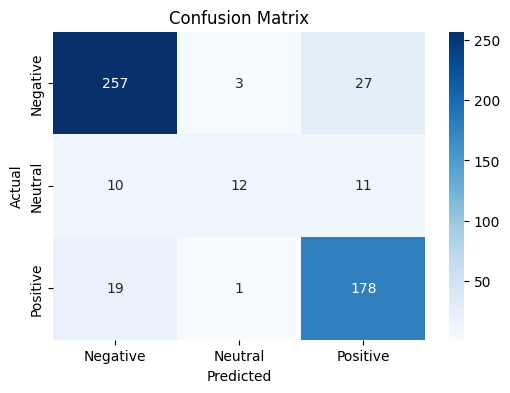

In [93]:
labels = ["Negative", "Neutral", "Positive"]
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [94]:
# Predict on Unlabeled Data

unlabeled = pd.read_csv("unlabeled_real_data.csv")
unlabeled['clean_text'] = unlabeled['TEXT'].apply(preprocess)
X_unlabeled = tfidf.transform(unlabeled['clean_text'])
unlabeled['predicted_sentiment'] = svm_best.predict(X_unlabeled)

# Save predictions
unlabeled.to_csv("unlabeled_predictions.csv", index=False)
print("Saved predictions to unlabeled_predictions.csv")

Saved predictions to unlabeled_predictions.csv
